In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2


In [2]:
from cods.od.data import MSCOCODataset
from cods.od.models import YOLOModel, DETRModel
import logging
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = (
    "1"  # chose the GPU. If only one, then "0"
)

logging.getLogger().setLevel(logging.INFO)

# set [COCO_PATH] to the directory to your local copy of the COCO dataset
COCO_PATH = "/datasets/shared_datasets/coco/"

data = MSCOCODataset(root=COCO_PATH, split="val")

calibration_ratio = (
    0.5  # set 0.5 to use 50% for calibration and 50% for testing
)

use_smaller_subset = True  # TODO: Temp

if use_smaller_subset:
    data_cal, data_val = data.split_dataset(
        calibration_ratio, shuffle=False, n_calib_test=800
    )
else:
    data_cal, data_val = data.split_dataset(calibration_ratio, shuffle=False)

# model and weights are downloaded from https://github.com/facebookresearch/detr
model = DETRModel(model_name="detr_resnet50", pretrained=True, device="cuda:0")
#model = YOLOModel(model_name="yolov8x.pt", pretrained=True, device="cpu")


print(f"{len(data) = }")
print(f"{len(data_cal) = }")
print(f"{len(data_val) = }")

Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


len(data) = 5000
len(data_cal) = 400
len(data_val) = 400


In [3]:
preds_cal = model.build_predictions(
    data_cal,
    dataset_name="mscoco",
    split_name="cal",
    batch_size=12,
    collate_fn=data._collate_fn,  # TODO: make this a default for COCO
    shuffle=False,
    force_recompute=False,  # False,
    deletion_method="nms",
)
preds_val = model.build_predictions(
    data_val,
    dataset_name="mscoco",
    split_name="test",
    batch_size=12,
    collate_fn=data._collate_fn,
    shuffle=False,
    force_recompute=False,  # False,
    deletion_method="nms",
)

# Filter the preds_cal and preds_val with confidence below 0.001


def filter_preds(preds, confidence_threshold=0.001):
    filters = [
        conf > confidence_threshold
        if (conf > confidence_threshold).any()
        else conf.argmin(0)[None]
        for conf in preds.confidences
    ]
    preds.pred_boxes = [pbs[f] for pbs, f in zip(preds.pred_boxes, filters)]
    preds.pred_cls = [pcs[f] for pcs, f in zip(preds.pred_cls, filters)]
    preds.confidences = [
        conf[f] for conf, f in zip(preds.confidences, filters)
    ]
    return preds


preds_cal = filter_preds(preds_cal)
preds_val = filter_preds(preds_val)

Predictions already exist, loading them...
Predictions already exist, loading them...


In [4]:
from cods.od.utils import match_predictions_to_true_boxes

# Avant
1.05 s ± 56.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [5]:
matching = match_predictions_to_true_boxes(preds_cal,"hausdorff", class_factor=None)
for i in range(3):  
    print(f"Matching = {matching[i]}, len={len(matching[i])}")

Matching = [[70], [10], [0], [70], [10], [10], [6], [66], [10], [70], [2], [30], [10], [70], [10], [10], [70], [10], [7]], len=19
Matching = [[12], [45], [33], [33], [1], [33], [0], [7], [33], [8], [33], [33], [10], [8]], len=14
Matching = [[0], [2], [1], [3], [2], [44], [6]], len=7


In [6]:
%%timeit 
match_predictions_to_true_boxes(preds_cal,"hausdorff", class_factor=None)

63.4 ms ± 93.5 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%lprun -f match_predictions_to_true_boxes match_predictions_to_true_boxes(preds_cal,"hausdorff", class_factor=None)

Timer unit: 1e-09 s

Total time: 0.0686834 s
File: /home/leo.andeol/envs/cods_13/cods/cods/od/utils.py
Function: match_predictions_to_true_boxes at line 366

Line #      Hits         Time  Per Hit   % Time  Line Contents
   366                                           def match_predictions_to_true_boxes(
   367                                               preds,
   368                                               distance_function,
   369                                               overload_confidence_threshold=None,
   370                                               verbose=False,
   371                                               hungarian=False,
   372                                               idx=None,
   373                                               class_factor: float = 0.25,
   374                                           ) -> None:
   375                                               """Matching predictions to true boxes. Done in place, modifies the preds obje

# Après

In [8]:
matching = match_predictions_to_true_boxes(preds_cal,"hausdorff")
for i in range(3):  
    print(f"Matching = {matching[i]}, len={len(matching[i])}")

Matching = [[70], [10], [0], [70], [10], [10], [6], [66], [10], [70], [2], [30], [10], [70], [10], [10], [70], [10], [7]], len=19
Matching = [[12], [45], [33], [33], [1], [33], [0], [7], [33], [8], [33], [33], [10], [8]], len=14
Matching = [[0], [2], [1], [3], [2], [44], [6]], len=7


In [9]:
%%timeit 
match_predictions_to_true_boxes(preds_cal,"hausdorff")

63.5 ms ± 84.9 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%lprun -f match_predictions_to_true_boxes match_predictions_to_true_boxes(preds_cal,"hausdorff")

Timer unit: 1e-09 s

Total time: 0.0677583 s
File: /home/leo.andeol/envs/cods_13/cods/cods/od/utils.py
Function: match_predictions_to_true_boxes at line 366

Line #      Hits         Time  Per Hit   % Time  Line Contents
   366                                           def match_predictions_to_true_boxes(
   367                                               preds,
   368                                               distance_function,
   369                                               overload_confidence_threshold=None,
   370                                               verbose=False,
   371                                               hungarian=False,
   372                                               idx=None,
   373                                               class_factor: float = 0.25,
   374                                           ) -> None:
   375                                               """Matching predictions to true boxes. Done in place, modifies the preds obje

# Tests

In [11]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
from cods.od.utils import assymetric_hausdorff_distance, assymetric_hausdorff_distance_old

In [12]:
idx = 11

In [13]:
tbs = preds_cal.true_boxes[idx].clone()
pbs = preds_cal.pred_boxes[idx].clone()

In [14]:
matching1 = []
distances1 = np.zeros((len(tbs), len(pbs)))
true_boxes = tbs
pred_boxes = pbs
for i, true_box in enumerate(true_boxes):
    distances = []
    for j, pred_box in enumerate(pred_boxes):
        dist = assymetric_hausdorff_distance_old(true_box, pred_box)
        dist = (
            dist.cpu().numpy()
            if isinstance(dist, torch.Tensor)
            else dist
        )
        distances.append(dist)  # .cpu().numpy())
        distances1[i, j] = dist
    
    matching1.append([np.argmin(distances)])  

In [15]:
true_boxes = tbs
pred_boxes = pbs

distances2 = assymetric_hausdorff_distance(true_boxes, pred_boxes)
matching2 = torch.argmin(distances2, dim=1).cpu().numpy().reshape(-1, 1).tolist()

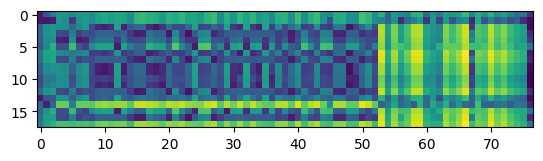

In [16]:
plt.imshow(distances1)

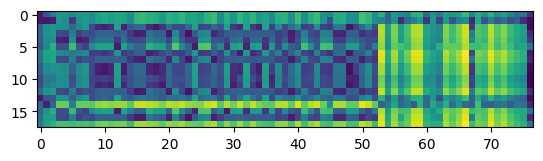

In [17]:
plt.imshow(distances2.cpu().numpy())

In [18]:
[print(x,y) for x,y in zip(matching1, matching2)];

[np.int64(0)] [0]
[np.int64(76)] [76]
[np.int64(76)] [76]
[np.int64(23)] [23]
[np.int64(6)] [6]
[np.int64(24)] [24]
[np.int64(48)] [48]
[np.int64(23)] [23]
[np.int64(76)] [76]
[np.int64(76)] [76]
[np.int64(76)] [76]
[np.int64(76)] [76]
[np.int64(23)] [23]
[np.int64(76)] [76]
[np.int64(1)] [1]
[np.int64(29)] [29]
[np.int64(23)] [23]
[np.int64(76)] [76]


# Conformalizing

In [19]:
from cods.od.cp import ODConformalizer

conf = ODConformalizer(
    backend="auto",
    guarantee_level="image",
    matching_function="mix",
    multiple_testing_correction=None,
    confidence_method="box_count_recall",
    localization_method="pixelwise",
    localization_prediction_set="multiplicative",
    classification_method="binary",
    classification_prediction_set="lac",
    device="cuda:0",
)

[2025-08-20 19:38:40:WARNING:cp.py:cp:748 - __init__ ] No multiple_testing_correction provided, assuming no correction is needed. The explicit list of alphas is expected for calibration.
[2025-08-20 19:38:40:INFO:cp.py:cp:184 - __init__ ] Defaulting to CRC backend
[2025-08-20 19:38:40:INFO:cp.py:cp:512 - __init__ ] Defaulting to CRC backend


In [20]:
model = DETRModel(model_name="detr_resnet50", pretrained=True, device="cuda:0")

[2025-08-20 19:38:40:INFO:models.py:models:30 - __init__ ] Model detr_resnet50 initialized


Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
conf.confidence_conformalizer.calibrate(preds_cal, 0.00001)

/home/leo.andeol/envs/cods_13/cods/cods/od/utils.py:493: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  Qst = torch.FloatTensor([np.array(Qs)]).to(device)
[2025-08-20 19:38:42:INFO:optim.py:optim:195 - optimize ] First risk: 0.0037406485062092543
[2025-08-20 19:38:42:WARNING:optim.py:optim:202 - optimize ] There does not exist any solution satisfying the constraints.
[2025-08-20 19:38:43:INFO:optim.py:optim:195 - optimize ] First risk: 0.0012468828354030848
[2025-08-20 19:38:43:WARNING:optim.py:optim:202 - optimize ] There does not exist any solution satisfying the constraints.


(1.0, 1.0)

In [22]:
%lprun -f conf.confidence_conformalizer.optimizer2_minus.optimize conf.calibrate(preds_cal,alpha_confidence=0.02,alpha_localization=0.05,alpha_classification=0.05,)


[2025-08-20 19:38:43:INFO:cp.py:cp:988 - calibrate ] Calibrating Confidence Conformalizer
[2025-08-20 19:38:43:INFO:cp.py:cp:398 - calibrate ] Replacing previously computed λ


[2025-08-20 19:38:44:INFO:optim.py:optim:195 - optimize ] First risk: 0.0037406485062092543
[2025-08-20 19:39:12:INFO:optim.py:optim:418 - optimize ] Solution Found: 0.9259868562221527 with risk 0.02025293931365013


--------------------------------------------------
Lambdas
	previous_lbd = 0.9259868562221527
	Last Lambda = 0.9258964955806732
	Other previous lbd = 0.9259868562221527
	Other current lbd = 0.9258964955806732
All risks raw (precomputed):
	Confidence Risk: 0.019421685487031937
	Localization Risk: 0.0024937656708061695
	Classification Risk: 0.0024937656708061695
	Max Risk: 0.019421685487031937
All risks monotonized (precomputed):
	Confidence Risk: 0.019421685487031937
	Localization Risk: 0.0024937656708061695
	Classification Risk: 0.0024937656708061695
	Max Risk: 0.019421685487031937
Confidence risk (recomputed):
	Confidence Risk: 0.016970237717032433
Comparison of the two :
	 (isclose) 0.9975000023841858
	 (eq) 0.9975000023841858
	Image 241 loss: tensor([0.], device='cuda:0') (eval) vs tensor([0.3333], device='cuda:0') (opti)
	Image 241 confidence: tensor([0.9993, 0.9794, 0.0740, 0.0028], device='cuda:0')
	Image 241 number of ground truths: 3
	Image 241 number of predictions: 3
--------

[2025-08-20 19:39:13:INFO:optim.py:optim:195 - optimize ] First risk: 0.0012468828354030848
[2025-08-20 19:39:44:INFO:optim.py:optim:418 - optimize ] Solution Found: 0.8939756602048874 with risk 0.02033606544137001


--------------------------------------------------
Lambdas
	previous_lbd = 0.8939756602048874
	Last Lambda = 0.893954761326313
	Other previous lbd = 0.8939756602048874
	Other current lbd = 0.893954761326313
All risks raw (precomputed):
	Confidence Risk: 0.019837312400341034
	Localization Risk: 0.0
	Classification Risk: 0.0
	Max Risk: 0.019837312400341034
All risks monotonized (precomputed):
	Confidence Risk: 0.019837312400341034
	Localization Risk: 0.0
	Classification Risk: 0.0
	Max Risk: 0.019837312400341034
Confidence risk (recomputed):


[2025-08-20 19:39:44:INFO:cp.py:cp:998 - calibrate ] Setting Confidence Threshold of Predictions
[2025-08-20 19:39:44:INFO:cp.py:cp:1010 - calibrate ] Calibrated Confidence λ : 0.9260
	 and associated Confidence Threshold : 0.07401314377784729
[2025-08-20 19:39:44:INFO:cp.py:cp:1025 - calibrate ] Matching Predictions to True Boxes


	Confidence Risk: 0.019886905327439308
Comparison of the two :
	 (isclose) 0.9975000023841858
	 (eq) 0.9975000023841858
	Image 321 loss: tensor([0.4000], device='cuda:0') (eval) vs tensor([0.6000], device='cuda:0') (opti)
	Image 321 confidence: tensor([0.9971, 0.9690, 0.1060, 0.0123, 0.0094, 0.0072, 0.0055, 0.0019, 0.0017, 0.0016, 0.0015, 0.0015, 0.0012], device='cuda:0')
	Image 321 number of ground truths: 5
	Image 321 number of predictions: 3
--------------------------------------------------


400it [00:00, 5558.44it/s]
[2025-08-20 19:39:44:INFO:cp.py:cp:1038 - calibrate ] Calibrating Localization Conformalizer
[2025-08-20 19:39:44:INFO:optim.py:optim:754 - optimize ] Using overload confidence threshold: 0.1060
[0.29, 0.32] -> λ=0.30517578125. Corrected Risk = 0.051: 100%|██████████| 13/13 [03:24<00:00, 15.75s/it]
[2025-08-20 19:43:09:INFO:cp.py:cp:268 - calibrate ] Calibrated λ for localization: 0.3173828125
[2025-08-20 19:43:09:INFO:cp.py:cp:1048 - calibrate ] Calibrated Localization λ : 0.3173828125
[2025-08-20 19:43:09:INFO:cp.py:cp:1056 - calibrate ] Calibrating Classification Conformalizer
[2025-08-20 19:43:09:WARNING:cp.py:cp:542 - calibrate ] Currently considering that there is only one matching prediction to each true box for classification pruposes. To add later how to aggregate if multiple preidctions matched.
[2025-08-20 19:43:09:INFO:optim.py:optim:754 - optimize ] Using overload confidence threshold: 0.1060
[1.00, 1.00] -> λ=0.9999978244304657. Corrected Risk =

Timer unit: 1e-09 s

Total time: 60.7362 s
File: /home/leo.andeol/envs/cods_13/cods/cods/od/optim.py
Function: optimize at line 42

Line #      Hits         Time  Per Hit   % Time  Line Contents
    42                                               def optimize(
    43                                                   self,
    44                                                   predictions: ODPredictions,
    45                                                   confidence_loss: ODLoss,
    46                                                   localization_loss: ODLoss,
    47                                                   classification_loss: ODLoss,
    48                                                   matching_function,
    49                                                   alpha: float,
    50                                                   device: str,
    51                                                   B: float = 1,
    52                                            